In [2]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'

# OLTraj Example 3: Lagrangian evolution of a chlorophyll patch

## Objective
To
follow the concentration of chlorophyll within a given water
mass that moves
from the location where it was observed.
This is an analysis in
a Lagrangian
reference frame and will be compared to the corresponding Eulerian
analysis.

##
Input data: 

Assume you have identified an interesting chl feature at a
given
location and time and you want to follow its evolution for 29 days before
and 29
days after the observation. 29 days before and after a given event is the
maximum length of a trajectory stored in one OLTraj file. For simplicity, in
this example we use this as the maximum length of time we want to follow a given
water mass. However, in principle multiple OLTraj files could be used to follow
a water mass for longer periods of time.

For this analysis you will use: 
1.
Satellite (e.g., Ocean Colour - Climate Change Initiative, OC-CCI) chl images
including the intial chl patch as well as areas around it to allow for its
advection with time.
2. OLTraj file for the day in which you observed the
initial chl patch.

To demonstrate the usefulness of the Lagrangian analysis, we
have selected a relatively dynamic region to the south east of Madagascar.

The
initial patch we want to follow was located approximately at 28 degress south
and 62.5 degrees east and was observed on January 16th, 2006.

## Code:

###
Import needed modules

In [3]:
import numpy as np
import xarray as xr
import scipy.interpolate as spint
import os
import glob
import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable



## Define region of interest

In [4]:
#### south east of Madagascar ##########################################################################

# parameters to subset OC-CCI data
region = {'name':'SE_Madagascar','lonmin':55 ,'lonmax':70, 'latmin':-32,'latmax':-24}
var_list = ['chlor_a'] # list of variables to be extracted from the original OC-CCI file (it can be expanded as follows: ['chlor_a', 'Rrs_412'])
chl_min = 0.02 # [mg/m3] this is for plotting
chl_max = 1. # [mg/m3] this is for plotting
chl_thresh = 0.2 # [mg/m3] used to extract OLTraj water parcels (i.e. pixels)

lonini = region['lonmin'] + (region['lonmax']-region['lonmin'])/2.
dlon = 1. # increment in longitude (degrees) to define approx area
latini = region['latmin'] + (region['latmax']-region['latmin'])/2.
dlat = 5. # increment in latitude (degrees) to define approx area
centre_lon = 141. # [degrees east]  central longitude for plotting

# coordinates to indentify the area approximately occupied by the observed feature
patch_lonini = 62.8 # central longitude [degrees east]
patch_dlon = 1.2 # increment in longitude [degrees east] to define approx area of feature. 
patch_latini = -28.9 # central latitude [degrees north]
patch_dlat = 1. # increment in latitude [degrees north] to define approx area of feature

# temporal slice
idate = dt.datetime(2006,1,16) # date of the "initial observation" (i.e., t0)
strdate = idate.strftime('%Y-%m-%d') # string version of the date
tslice1 = (idate - dt.timedelta(days=29)).strftime("%Y-%m-%d")  # maximum start date set at 29 days before idate
tslice2 = (idate + dt.timedelta(days=29)).strftime("%Y-%m-%d")  # maximum end date set at 29 days before idate

# this is the OLTraj time index for the time the initial water patch was observed
# (it is also the central temporal slice in the OLTraj product)
itime0 = 29
#############################################################################



### Read chl data

In [5]:
# open chl dataset using OPENDAP THREDDS (i.e. there is no need to download data files)
GEO_DAILY_THREDDS_string = 'https://rsg.pml.ac.uk/thredds/dodsC/CCI_ALL-v5.0-DAILY'
all_CHL = xr.open_dataset(GEO_DAILY_THREDDS_string)

# read subsetted data
ds_CHL = all_CHL[var_list].loc[ {  'time': slice(tslice1, tslice2), 
                                    'lat': slice(region['latmax'], region['latmin']), # latmax before latmin, because of how data are stored in the OC-CCI product
                                    'lon': slice(region['lonmin'], region['lonmax'])}  ]  

# sort along lat dimension, because OC-CCI latitudes are in descending order
ds_CHL = ds_CHL.sortby('lat')

# close all_CHL dataset
all_CHL.close()

### Read OLTraj data

In [6]:
OLTraj_THREDDS_string = 'http://dap.ceda.ac.uk/thredds/dodsC/neodc/oltraj/data/v2.2/'
fn_OLT = OLTraj_THREDDS_string + f'{idate.strftime("%Y")}/{idate.strftime("%Y%m%d")}_oltraj_uv_global.nc'

# open dataset
all_OLT = xr.open_dataset(fn_OLT)

# subset OLTraj dataframe    
ds_OLT_patch = all_OLT.loc[{ 'lat': slice(patch_latini-patch_dlat, patch_latini+patch_dlat), 
                             'lon': slice(patch_lonini-patch_dlon,  patch_lonini+patch_dlon),     
                            }]    

# set appropriate attributes for OLTraj (needed for plotting)
ds_OLT_patch['time'].attrs["standard_name"] = "time"
ds_OLT_patch['time'].attrs["axis"] =  "T"

# close all_OLT dataset
all_OLT.close()

### Plot chl map with initially observed patch

/users/modellers/gdal/miniconda3/envs/OLTraj/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


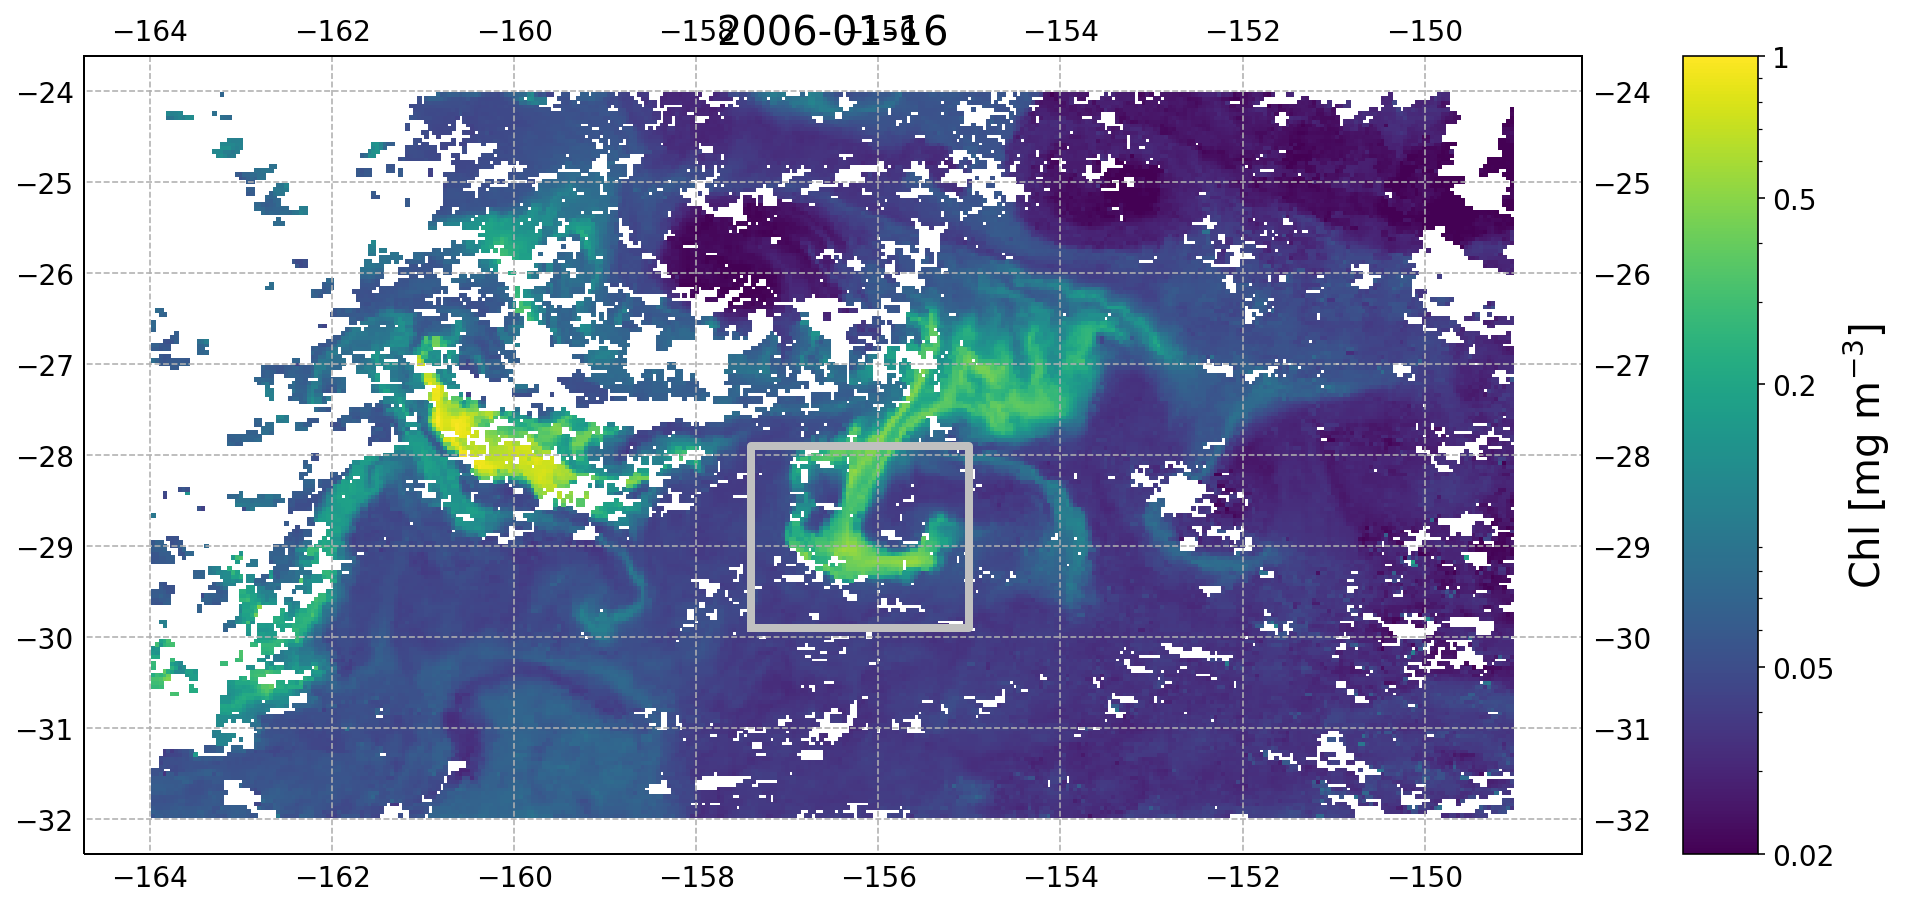

In [7]:
lbl_color = 'k'


fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(  central_longitude=centre_lon   )  )

# extract chl at the time of observation
CHL_t0 = ds_CHL['chlor_a'].sel(time=strdate)

# plot chl on a log scale
pc = ax.pcolormesh(  CHL_t0['lon'], CHL_t0['lat'], CHL_t0, transform=ccrs.PlateCarree(central_longitude=centre_lon), norm=colors.LogNorm(vmin=chl_min, vmax=chl_max)  )

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=lbl_color, facecolor='darkgray'))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
gl.xlabel_style = {'size': 14, 'color': lbl_color}
gl.ylabel_style = {'size': 14, 'color': lbl_color}
gl.right_labels = False
gl.top_labels = False

ts = pd.to_datetime(str(CHL_t0.time.values)) 
d = ts.strftime('%Y-%m-%d')
ax.set_title(d, color=lbl_color, fontsize=20)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.7, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(pc, cax=ax_cb)
cb.set_label('Chl [mg m$^{-3}$]', color=lbl_color, fontsize=20)
cb.ax.autoscale(False)
cb.set_ticks([0.02, 0.05, 0.2, 0.5, 1])
cb.ax.set_yticklabels(["0.02", "0.05", "0.2", "0.5", "1"], color=lbl_color, fontsize=14)


ax.plot([patch_lonini-patch_dlon, patch_lonini+patch_dlon, patch_lonini+patch_dlon, patch_lonini-patch_dlon, patch_lonini-patch_dlon],
        [patch_latini-patch_dlat, patch_latini-patch_dlat, patch_latini+patch_dlat, patch_latini+patch_dlat, patch_latini-patch_dlat], 
        lw=4, c='silver',transform=ccrs.PlateCarree(central_longitude=centre_lon))



The patch with relatively high chl (green-yellow colours) inside the black
rectangle is the chl feature we want to follow.
<br/><br/>

### Identify OLTraj
data within the patch
To do this, we select trajectories
that are within the
black rectangle with `chl` values greater than `chl_thresh`.
We will then need
to interpolate the chl data onto the same spatial grid as the
OLTraj data.

In [8]:
# function to interpolate chl field onto OLTraj product at a given time
# Crucial point: in this example, and in this fuction, we assume that chl and OLTraj share the same time coordinate 
def interp_chl_on_OLTraj(dsCHL, dsOLT, interp_time):
    # ds_CHL: xarray dataset with the chl data (if working on a small region, slice these arrays before this function to speed things up)
    # ds_OLT: xarray dataset with the OLTraj product
    # interp_time: date string at which we want the interpolated chl onto the OLTraj geographic coordinate
    
    # Since input field is on a regular grid but the trajectory positions are not,
    # we can use RegularGridInterpolator from scipy.interpolate
    
    # Slice chl data closest to the given time (see xarray documentation for "closest")
    CHL_it = dsCHL['chlor_a'].sel(time=interp_time)
    
    # Extract chl coordinates 
    lonCHL = CHL_it['lon'].values
    latCHL = CHL_it['lat'].values
    
#     # Need to flip lat and chl matrix because OCCCI lat are in descending order
#     latCHL = np.flipud(latCHL)
#     CHL = np.flipud(CHL_it.values)
    CHL = CHL_it.values

    # Create the interpolation function
    finterp = spint.RegularGridInterpolator((latCHL,lonCHL), CHL, method='linear')
        
    # extract OLTraj data closest to the given time (see xarray documentation for "closest")
    latOLT = dsOLT['trajlat'].sel(time=interp_time).values
    lonOLT = dsOLT['trajlon'].sel(time=interp_time).values

    # Get lat and lon dimensions used later to reshpe 1d array and 2d array
    londim = dsOLT['lon'].shape
    latdim = dsOLT['lat'].shape
    
    # Convert 2D OLTraj coordinates into 1D arrays
    latOLT = latOLT.ravel()
    lonOLT = lonOLT.ravel()

    # Interpolate Chl over trajectory positions
    intCHL = finterp(np.array([latOLT,lonOLT]).T) # Need to transpose to have lat and lon as columns of the input matrix
    
    # Convert into 2D matrix
    intCHL = intCHL.reshape(latdim+londim)
    
    return intCHL


In [9]:
# Interpolate Chl on trajectory positions at strdate
znew = interp_chl_on_OLTraj(ds_CHL, ds_OLT_patch, strdate)

# select pixels with chl > chl_thresh to define water patches to follow in the LAgrangian framework
igood = np.where(znew > chl_thresh)

/users/modellers/gdal/miniconda3/envs/OLTraj/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


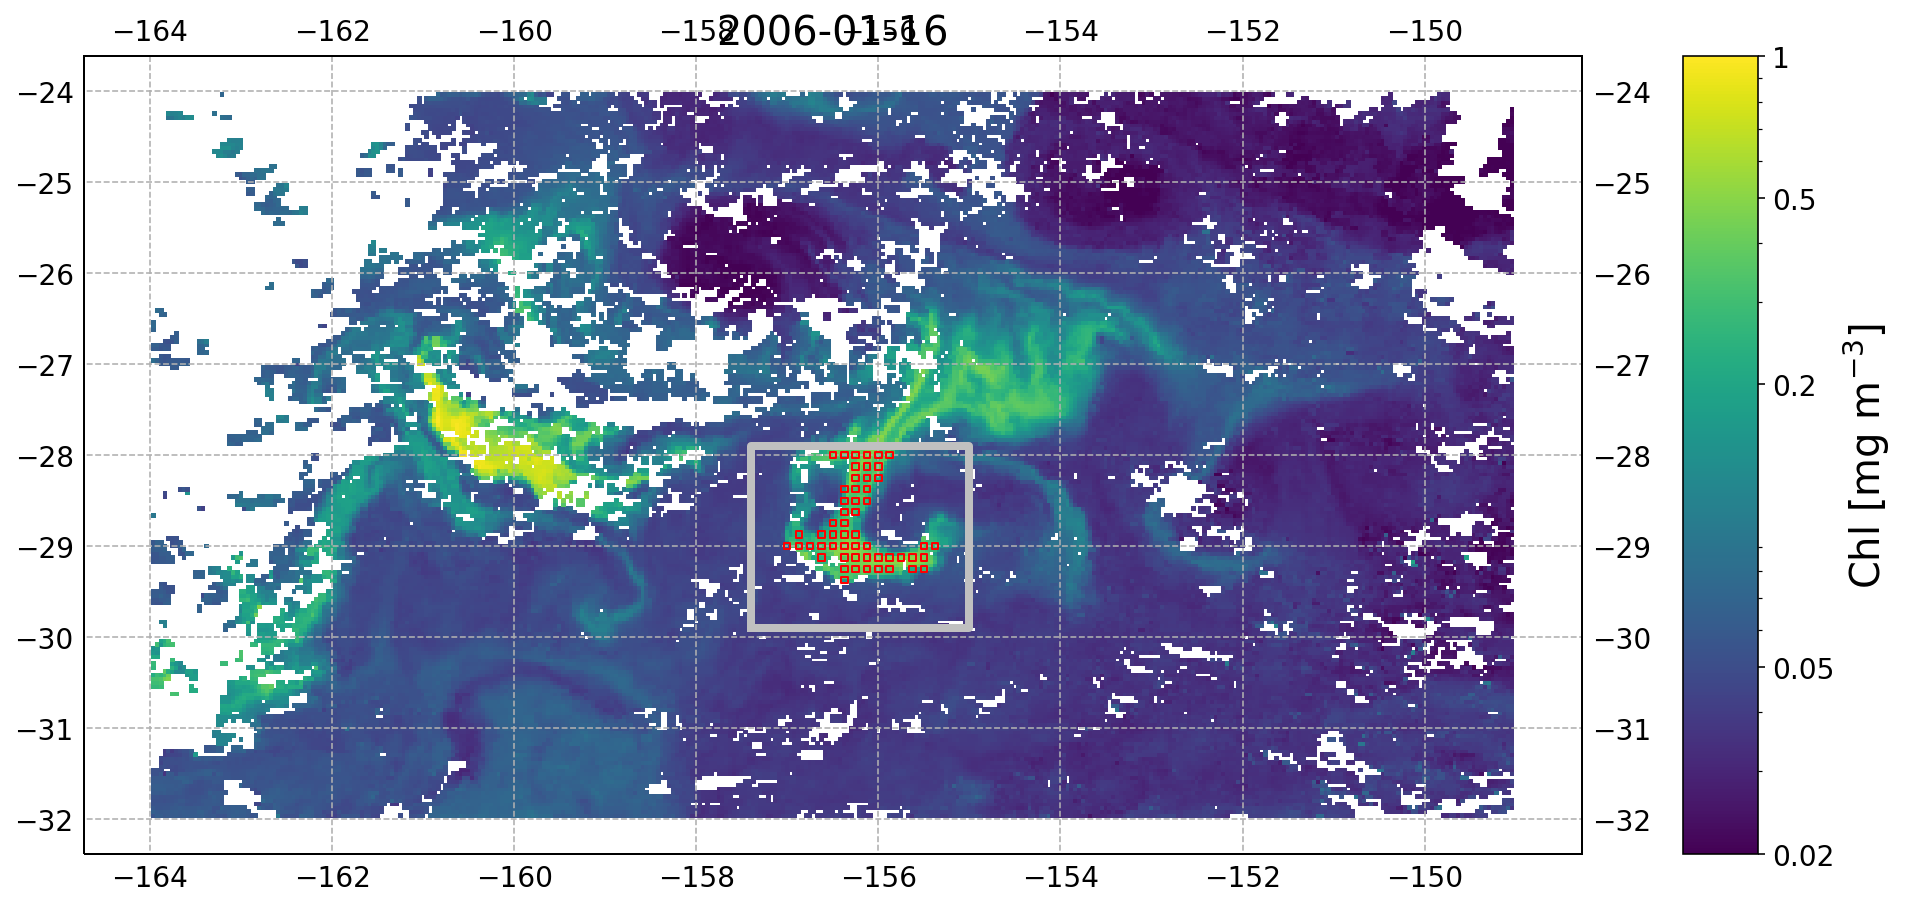

In [10]:
# plot selected OLTraj pixels over the chl patch
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(  central_longitude=centre_lon   )  )

# extract chl at the time of observation
CHL_t0 = ds_CHL['chlor_a'].sel(time=strdate)

# plot chl on a log scale
pc = ax.pcolormesh(  CHL_t0['lon'], CHL_t0['lat'], CHL_t0, transform=ccrs.PlateCarree(central_longitude=centre_lon), norm=colors.LogNorm(vmin=chl_min, vmax=chl_max)  )

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=lbl_color, facecolor='darkgray'))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
gl.xlabel_style = {'size': 14, 'color': lbl_color}
gl.ylabel_style = {'size': 14, 'color': lbl_color}
gl.right_labels = False
gl.top_labels = False

ts = pd.to_datetime(str(CHL_t0.time.values)) 
d = ts.strftime('%Y-%m-%d')
ax.set_title(d, color=lbl_color, fontsize=20)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.7, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(pc, cax=ax_cb)
cb.set_label('Chl [mg m$^{-3}$]', color=lbl_color, fontsize=20)
cb.ax.autoscale(False)
cb.set_ticks([0.02, 0.05, 0.2, 0.5, 1])
cb.ax.set_yticklabels(["0.02", "0.05", "0.2", "0.5", "1"], color=lbl_color, fontsize=14)


ax.scatter(ds_OLT_patch['trajlon'].values[itime0,igood[0],igood[1]], 
           ds_OLT_patch['trajlat'].values[itime0,igood[0],igood[1]], marker="s", s=10,
           transform=ccrs.PlateCarree(central_longitude=centre_lon), 
           facecolor='none', edgecolors="r", zorder=60)

ax.plot([patch_lonini-patch_dlon,patch_lonini+patch_dlon,patch_lonini+patch_dlon,patch_lonini-patch_dlon,patch_lonini-patch_dlon],
        [patch_latini-patch_dlat,patch_latini-patch_dlat,patch_latini+patch_dlat,patch_latini+patch_dlat,patch_latini-patch_dlat], 
        lw=4, c='silver',transform=ccrs.PlateCarree(central_longitude=centre_lon))



The red squares represent the locations of the OLTraj pixels selected to track
the chl patch.
<br/><br/>

**Now we plot the backward (pink) and forward (cyan)
trajectories on top of the
chl image at the time of observation to see where the
patch came from and where
it moved**

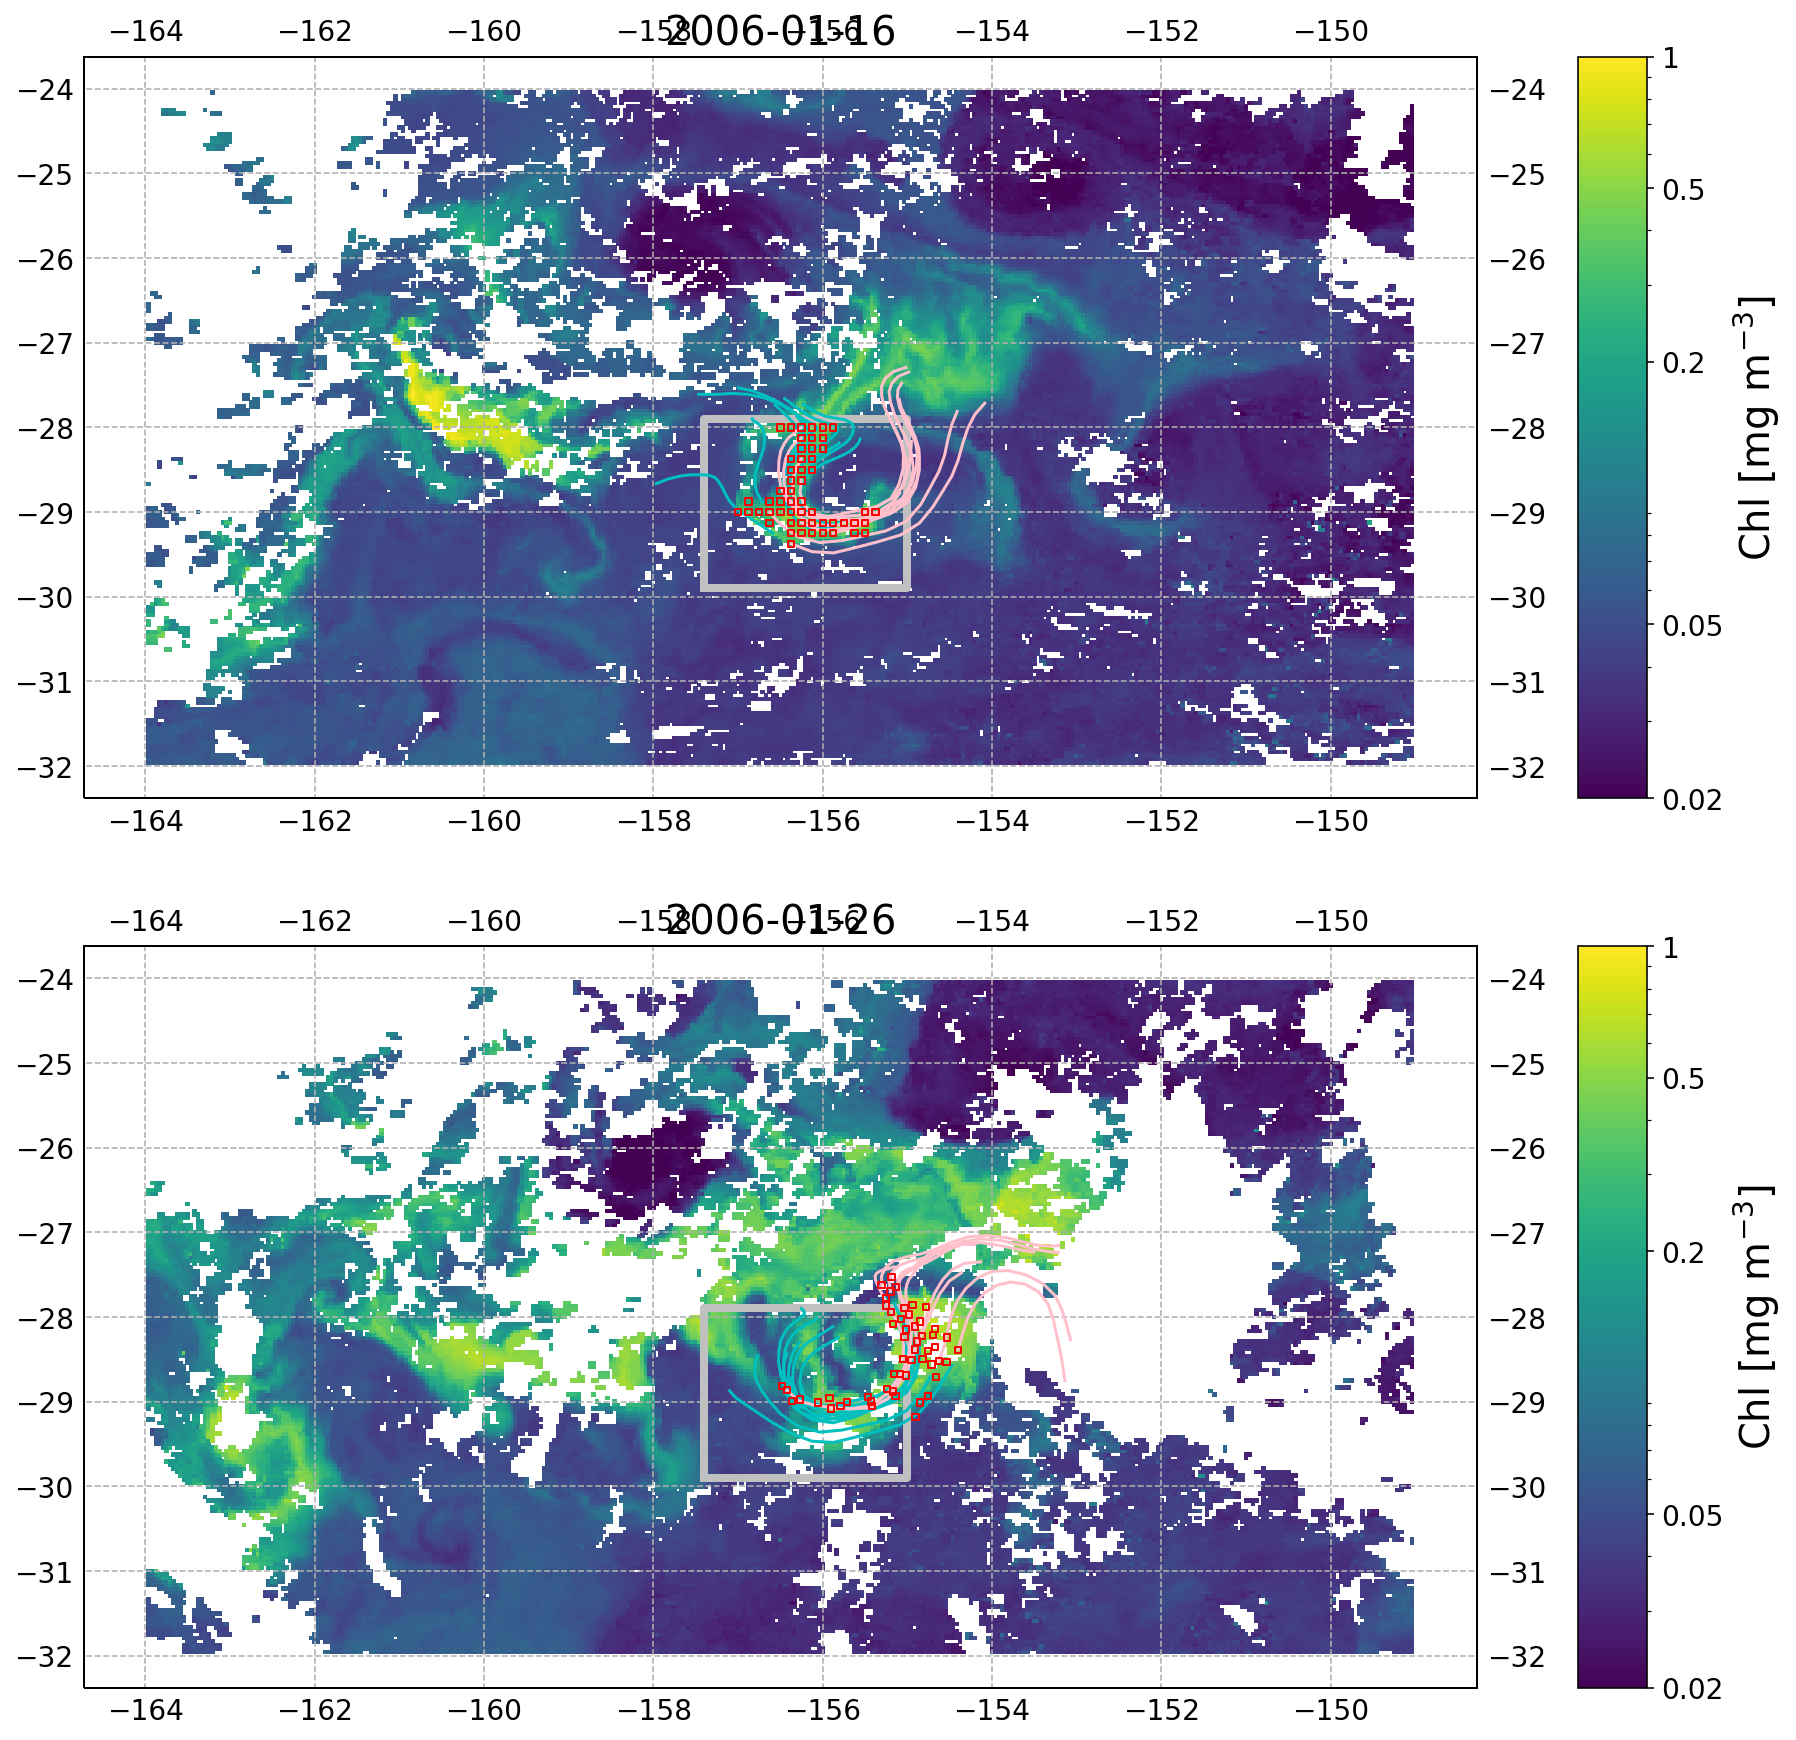

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=centre_lon)})
fig.set_size_inches(15,15)

# set time index for plotting
it2plot = itime0

for iax in range(2):
    
    # chage time to plot for second subplot
    if iax>0:
        it2plot = it2plot+10
    
    # extract chl at the time of observation
    CHL_t0 = ds_CHL['chlor_a'].isel(time=it2plot)
    
    # plot chl on a log scale
    pc = ax[iax].pcolormesh(  CHL_t0['lon'], CHL_t0['lat'], CHL_t0, transform=ccrs.PlateCarree(central_longitude=centre_lon), norm=colors.LogNorm(vmin=chl_min, vmax=chl_max)  )

    # add gridlines and labels
    gl = ax[iax].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
    gl.xlabel_style = {'size': 14, 'color': lbl_color}
    gl.ylabel_style = {'size': 14, 'color': lbl_color}
    gl.right_labels = False
    gl.top_labels = False

    # set title   
    ts = pd.to_datetime(str(ds_OLT_patch.time[it2plot].values)) 
    d = ts.strftime('%Y-%m-%d')
    ax[iax].set_title(d, color=lbl_color, fontsize=20)

    divider = make_axes_locatable(ax[iax])
    ax_cb = divider.new_horizontal(size="5%", pad=0.7, axes_class=plt.Axes)

     # prepare colorbar
    fig.add_axes(ax_cb)
    cb = plt.colorbar(pc, cax=ax_cb)
    cb.set_label('Chl [mg m$^{-3}$]', color=lbl_color, fontsize=20)
    cb.ax.autoscale(False)
    cb.set_ticks([0.02, 0.05, 0.2, 0.5, 1])
    cb.ax.set_yticklabels(["0.02", "0.05", "0.2", "0.5", "1"], color=lbl_color, fontsize=14)

    # plot location of OLTraj patch
    ax[iax].scatter(ds_OLT_patch['trajlon'].values[it2plot,igood[0],igood[1]], 
               ds_OLT_patch['trajlat'].values[it2plot,igood[0],igood[1]], marker="s", s=10,
               transform=ccrs.PlateCarree(central_longitude=centre_lon), 
               facecolor='none', edgecolors="r", zorder=60)

    # plot patch containing the chl feature 
    ax[iax].plot([patch_lonini-patch_dlon,patch_lonini+patch_dlon,patch_lonini+patch_dlon,patch_lonini-patch_dlon,patch_lonini-patch_dlon], \
            [patch_latini-patch_dlat,patch_latini-patch_dlat,patch_latini+patch_dlat,patch_latini+patch_dlat,patch_latini-patch_dlat], \
            lw=4, c='silver',transform=ccrs.PlateCarree(central_longitude=centre_lon));

    # set stride for which trajectories to plot
    traj_stride = 5
    
    # set length of trajectoies to plot
    trajdays2plot = 15

    # plot backward trajectories
    ax[iax].plot(ds_OLT_patch['trajlon'].values[it2plot-trajdays2plot:it2plot,igood[0],igood[1]][:,::traj_stride], 
               ds_OLT_patch['trajlat'].values[it2plot-trajdays2plot:it2plot,igood[0],igood[1]][:,::traj_stride], 
               transform=ccrs.PlateCarree(central_longitude=centre_lon), 
               color='c', alpha=1);

    # plot forward trajectories
    ax[iax].plot(ds_OLT_patch['trajlon'].values[it2plot:it2plot+trajdays2plot,igood[0],igood[1]][:,::traj_stride], 
               ds_OLT_patch['trajlat'].values[it2plot:it2plot+trajdays2plot,igood[0],igood[1]][:,::traj_stride], 
               transform=ccrs.PlateCarree(central_longitude=centre_lon), 
               color='pink', alpha=1);


**Now we generate a dynamic plot showing the location of the initially observed
patch (black squares) and the location of the patch at any given day before and
after the initial observation (red squares).**

In [13]:
import holoviews as hv
from holoviews import opts
import hvplot.pandas
import hvplot.xarray

hv.extension('bokeh')

startdate = tslice1
enddate = tslice2


# convert ds_OLT_patch to a pandas DataFrame
trajlat = ds_OLT_patch.sel(time = slice(startdate, enddate)).trajlat.values[:,igood[0], igood[1]]
trajlon = ds_OLT_patch.sel(time = slice(startdate, enddate)).trajlon.values[:,igood[0], igood[1]]
time = pd.to_datetime(ds_OLT_patch.sel(time = slice(startdate, enddate)).time.values) #- dt.timedelta(days=1)


# initialize datetime64 array of the same size as trajlon
tmp = np.Datetime64().astype('M8[ns]')
t64 = np.tile(tmp, [trajlon.shape[0], trajlon.shape[1]])

# fill datetime64 array with times
for ic in range(trajlon.shape[1]):
    t64[:,ic] = time


# create a pandas dataframe for oltraj dataset
olt_pd = pd.DataFrame({"lat" : np.ravel(trajlat), 
                   "lon" : np.ravel(trajlon), 
                   "time": np.ravel(t64) 
                  })        


#### create overlay of two datasets
# create chl object
chl_hv = ds_CHL.sel(time=slice(startdate, enddate)).\
        hvplot( groupby='time', logz=True, colorbar=True,  cmap='viridis').\
                redim.range(lon = (55, 70), 
                            lat = (-32,  -24),
                            chlor_a = (chl_min, chl_max), 
                           )
# create OLT object of central date
t_default = np.datetime64(idate)
olt_hv0 = olt_pd.loc[(olt_pd['time']==t_default)].\
            hvplot.points('lon', 'lat', marker='s', line_color='k', line_width=0.5, fill_alpha=0, size=15)  




# create olt object
olt_hv = olt_pd.hvplot.points('lon', 'lat', groupby='time', marker='s', line_color='red', line_width=0.5, fill_alpha=0, size=15)  

# create overlay
overlay = chl_hv * olt_hv0 * olt_hv

# set location of slider to below the plot
hv.output(widget_location='bottom')


# set size of plot and starting time, and visualise
overlay.opts(  width = 800, 
              height = 400).redim.default(time=t_default)




ImportError: cannot import name 'append_docstring' from 'bokeh.util.string' (/users/modellers/gdal/miniconda3/envs/OLTraj/lib/python3.7/site-packages/bokeh/util/string.py)

You can change the time by moving the slide bar with your mouse or by clicking
on it and then using the arrow keys (note: the first time you will change dates
it will take longer, but after that images should be updating more rapidly). Red
boxes correspond to the location of the patch at the specific time plotted. Back
boxes represent the location of the "initial observation" on 2006-01-16.
<br/><br/>

**Next, we will extract and compare the Lagrangian and Eulerian time
series.**

In [82]:
###### Extract Lagrangian time series of Chl
# Interpolate ds_CHL on the OLT positions at each timestep
# We need to use the full chl field because particles might be advected outside the chl domain used for the plot
# (if no chl data are available for a given location, then the interpolation function will return an error)
for ii, it in enumerate(ds_CHL['time'].values):
    _CHL_Lag = interp_chl_on_OLTraj(ds_CHL, ds_OLT_patch, it)
    if ii == 0:
        CHL_Lag = _CHL_Lag[None,...]
    else:
        CHL_Lag = np.concatenate((CHL_Lag, _CHL_Lag[None,...]), axis=0)
        
# CHL_Lag is an array of points with two dimensions: the first dimension (length = 59) is time, the second dimension
# (length = 87) contains the chl values interpolated onto the OLTraj pixels (i.e., black rectangles in the above figures) 
# as they moved over time. 
# 
# CHL_Lag[29,:] are the chl values observed on 2006-01-16 on the OLTraj pixels selected.
# CHL_Lag[28,:] are the chl values observed on 2006-01-15 on the same OLTraj pixels, but accounting 
#               for the movement of the water masses
# CHL_Lag[30,:] are the chl values observed on 2006-01-17 on the same OLTraj pixels, but accounting 
#               for the movement of the water masses
        
        
# Select only particles within the given chl threshold at time0 (i.e., idate/strdate)
CHL_Lag = CHL_Lag[:, igood[0], igood[1]] 


In [83]:
###### Extract Eulerian time series of Chl
# interpolate ds_CHL onto the same coordinates as ds_OLT_patch
ds_interp_CHL = ds_CHL.interp(lat=ds_OLT_patch['lat'], lon=ds_OLT_patch['lon'])

# extract Eulerian time series for the igood points
CHL_Eul = ds_interp_CHL['chlor_a'].values[:, igood[0], igood[1]]

In [170]:
# count number of NaN values at each time step
iNaNLag = np.count_nonzero(~np.isnan(CHL_Lag),axis=1)
iNaNEul = np.count_nonzero(~np.isnan(CHL_Eul),axis=1)

# create index where time series have at least 20 points
ngoodpoints = 10
iLag = np.where(iNaNLag>=ngoodpoints)[0]
iEul = np.where(iNaNEul>=ngoodpoints)[0]

/users/modellers/gdal/miniconda3/envs/OLTraj_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/users/modellers/gdal/miniconda3/envs/OLTraj_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


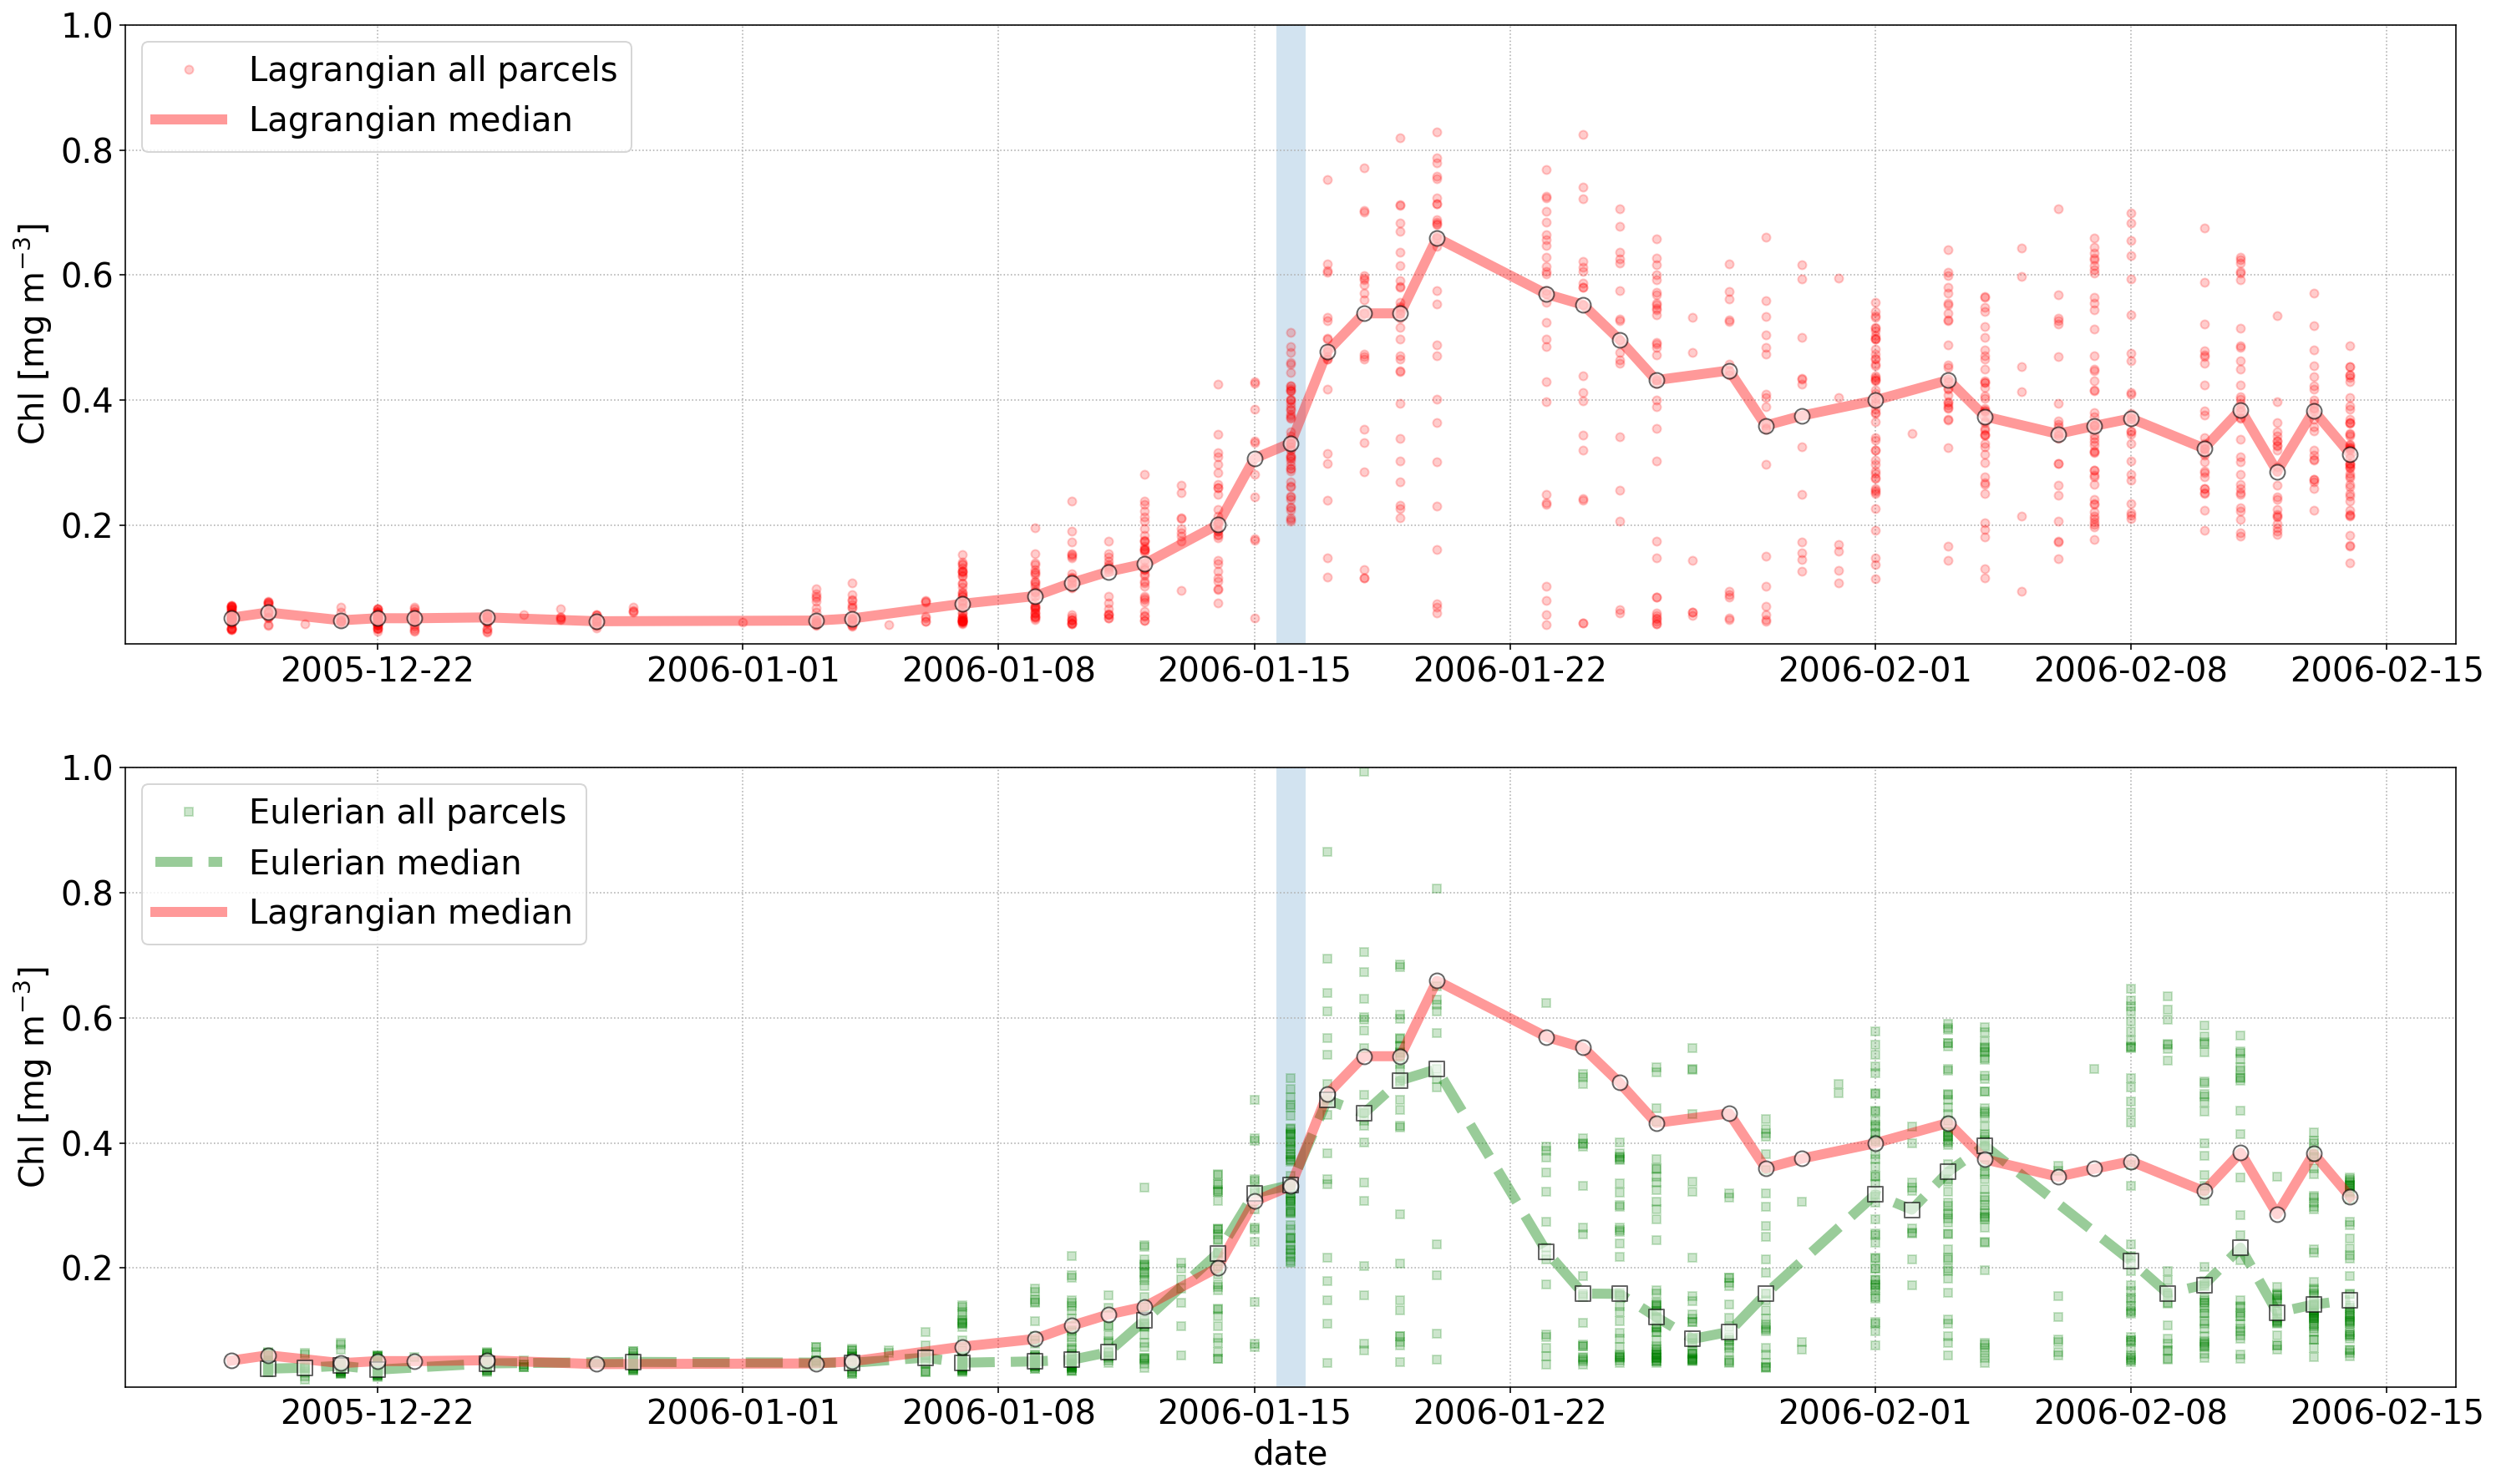

In [181]:
# now plot both the Eulerian and Lagrangian time series
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(211)

# compute time series of medians
CHL_Lag_med = np.nanmedian(CHL_Lag, axis=1)

ax.plot(ds_CHL['time'], CHL_Lag, 'ro', label='Lagrangian all parcels', ms=5, alpha=0.2)
ax.plot(ds_CHL['time'][iLag], CHL_Lag_med[iLag], 'r', label='Lagrangian median', lw=6, alpha=0.4)
ax.scatter(ds_CHL['time'][iLag], CHL_Lag_med[iLag], 80, 'w', edgecolors="k", zorder=60, alpha=0.6)
ax.bar(idate, 10, alpha=0.2)

fs_xticklbls = 20
ax.set_ylabel("Chl [mg m$^{-3}$]", fontsize=20, color=lbl_color)
ax.tick_params(axis='x', colors=lbl_color)
ax.tick_params(axis='y', colors=lbl_color)
plt.setp(ax.get_xticklabels(), fontsize=fs_xticklbls)
plt.setp(ax.get_yticklabels(), fontsize=fs_xticklbls)

ax.legend(fontsize=20)

# this is to only plot the legend for the median value
# extract from the legend labels only the median values
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:], fontsize=20, loc='upper left')
ax.grid('on', linestyle=':')

ax.set_ylim(0.01,1)
# ax.set_yscale('log')


### Plot Eulerian time series
ax2 = fig.add_subplot(212)

# compute time series of medians
CHL_Eul_med = np.nanmedian(CHL_Eul, axis=1)

ax2.plot(ds_CHL['time'], CHL_Eul, 'gs', label='Eulerian all parcels', ms=5, alpha=0.2)
ax2.bar(idate, 10, alpha=0.2)

ax2.plot(ds_CHL['time'][iEul], CHL_Eul_med[iEul], 'g', label='Eulerian median', lw=6, alpha=0.4, linestyle="--")
ax2.scatter(ds_CHL['time'][iEul], CHL_Eul_med[iEul], 80, 'w', edgecolors="k", zorder=60, marker='s', alpha=0.6)

ax2.plot(ds_CHL['time'][iLag], CHL_Lag_med[iLag], 'r', label='Lagrangian median', lw=6, alpha=0.4)
ax2.scatter(ds_CHL['time'][iLag], CHL_Lag_med[iLag], 80, 'w', edgecolors="k", zorder=60, alpha=0.6)
ax2.grid('on', linestyle=':')

ax2.set_ylim(0.01,1)
# ax2.set_yscale('log')

ax2.set_xlabel("date", fontsize=20, color=lbl_color)
ax2.set_ylabel("Chl [mg m$^{-3}$]", fontsize=20, color=lbl_color)
ax2.tick_params(axis='x', colors=lbl_color)
ax2.tick_params(axis='y', colors=lbl_color)
plt.setp(ax2.get_xticklabels(), fontsize=fs_xticklbls)
plt.setp(ax2.get_yticklabels(), fontsize=fs_xticklbls)

# this is to only plot the legend for the median value
# extract from the legend labels only the median values
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[-3:], labels[-3:], fontsize=20, loc='upper left')


Note how the Lagrangian and Eulerian time series (red and green lines,
respectively) diverge after the initial observation (2006-01-16, blue vertical
bar) due to the movement of the water masses. Before 2006-01-16 chl values were
very low and it is more difficult to see differences.
Note also that even if chl
values are similar around 2006-02-01, the patch of water is at a
location that is considerably different from the location of the intial
observation.